# Aggregating and weighting diverse data

In this notebook, we illustrate the aggregation of various data, and how to combine that with an adaptive scheme of computing weights.

## Aggregating diverse distance functions

We want to combine different distance metrics operating on subsets of the data to one distance value. As a toy model, assume we want to combine a Laplace and a Normal distance.

In [1]:
import pyabc
import numpy as np
import scipy as sp
from scipy import stats
import os
import tempfile
import matplotlib.pyplot as plt

p_true = {'p0': 0, 'p1': 0}

def model(p):
    return {'s0': p['p0'] + 0.1 * sp.randn(), 
            's1': p['p1'] + 0.1 * sp.randn()}

observation = {'s0': 0, 's1': 0}

def distance0(x, x_0):
    return abs(x['s0'] - x_0['s0'])

def distance1(x, x_0):
    return (x['s1'] - x_0['s1'])**2

# prior                           
prior = pyabc.Distribution(
    p0=pyabc.RV("uniform", -1, 2),
    p1=pyabc.RV("uniform", -1, 2))

The key is now to use `pyabc.distance.AggregatedDistance` to combine both.

INFO:History:Start <ABCSMC(id=14, start_time=2019-10-07 23:08:05.745116, end_time=None)>
INFO:Epsilon:initial epsilon is 0.8414016925279781
INFO:ABC:t:0 eps:0.8414016925279781
INFO:ABC:t:1 eps:0.5039833593536793
INFO:ABC:t:2 eps:0.3175987102774255
INFO:ABC:t:3 eps:0.22325981460954186
INFO:ABC:t:4 eps:0.12595727195319925
INFO:ABC:t:5 eps:0.0751407559654889
INFO:History:Done <ABCSMC(id=14, start_time=2019-10-07 23:08:05.745116, end_time=2019-10-07 23:08:09.595240)>


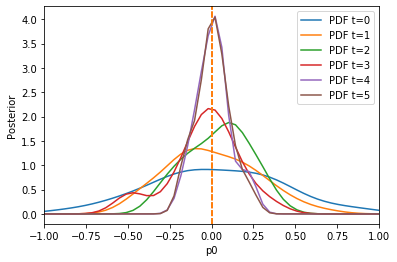

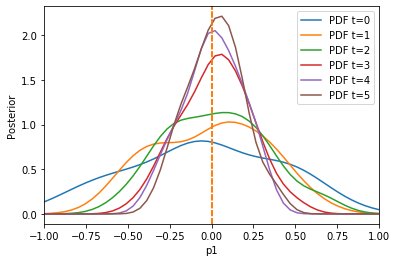

In [2]:
distance = pyabc.AggregatedDistance([distance0, distance1])

abc = pyabc.ABCSMC(model, prior, distance)
db_path = "sqlite:///" + os.path.join(tempfile.gettempdir(), "tmp.db")
abc.new(db_path, observation)
history1 = abc.run(max_nr_populations=6)

# plotting

def plot_history(history):
    fig, ax = plt.subplots()
    for t in range(history.max_t + 1):
        df, w = history.get_distribution(m=0, t=t)
        pyabc.visualization.plot_kde_1d(df, w, xmin=-1, xmax=1,
                                        x='p0', ax=ax,
                                        label="PDF t={}".format(t),
                                        refval=p_true)
    ax.legend()

    fig, ax = plt.subplots()
    for t in range(history.max_t + 1):
        df, w = history.get_distribution(m=0, t=t)
        pyabc.visualization.plot_kde_1d(df, w, xmin=-1, xmax=1,
                                        x='p1', ax=ax,
                                        label="PDF t={}".format(t),
                                        refval=p_true)
    ax.legend()
    
plot_history(history1)

## Weighted aggregation

A problem with the previous aggregation of distance function is that usually they vary on different scales. In order to account for all in a similar manner, one thing one can do is to weight them.

Let us look at a simple example of two summary statistics which vary on very different scales:

INFO:History:Start <ABCSMC(id=15, start_time=2019-10-07 23:08:10.393416, end_time=None)>
INFO:Epsilon:initial epsilon is 4614.696873048764
INFO:ABC:t:0 eps:4614.696873048764
INFO:ABC:t:1 eps:1004.7119593572107
INFO:ABC:t:2 eps:207.1728011209345
INFO:ABC:t:3 eps:66.96566644107422
INFO:ABC:t:4 eps:14.791196089069988
INFO:ABC:t:5 eps:3.8382851702273895
INFO:History:Done <ABCSMC(id=15, start_time=2019-10-07 23:08:10.393416, end_time=2019-10-07 23:08:41.808704)>


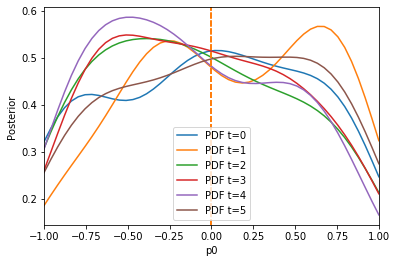

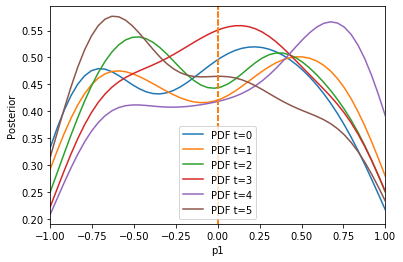

In [3]:
import pyabc
import numpy as np
import scipy as sp
from scipy import stats
import os
import tempfile
import matplotlib.pyplot as plt

p_true = {'p0': 0, 'p1': 0}

def model(p):
    return {'s0': p['p0'] + 0.1 * sp.randn(), 
            's1': p['p1'] + 100 * sp.randn()}

observation = {'s0': 0, 's1': 0}

def distance0(x, x_0):
    return abs(x['s0'] - x_0['s0'])

def distance1(x, x_0):
    return (x['s1'] - x_0['s1'])**2

# prior                           
prior = pyabc.Distribution(
    p0=pyabc.RV("uniform", -1, 2),
    p1=pyabc.RV("uniform", -1, 2))

distance = pyabc.AggregatedDistance([distance0, distance1])

abc = pyabc.ABCSMC(model, prior, distance)
db_path = "sqlite:///" + os.path.join(tempfile.gettempdir(), "tmp.db")
abc.new(db_path, observation)
history1 = abc.run(max_nr_populations=6)

# plotting

def plot_history(history):
    fig, ax = plt.subplots()
    for t in range(history.max_t + 1):
        df, w = history.get_distribution(m=0, t=t)
        pyabc.visualization.plot_kde_1d(df, w, xmin=-1, xmax=1,
                                        x='p0', ax=ax,
                                        label="PDF t={}".format(t),
                                        refval=p_true)
    ax.legend()

    fig, ax = plt.subplots()
    for t in range(history.max_t + 1):
        df, w = history.get_distribution(m=0, t=t)
        pyabc.visualization.plot_kde_1d(df, w, xmin=-1, xmax=1,
                                        x='p1', ax=ax,
                                        label="PDF t={}".format(t),
                                        refval=p_true)
    ax.legend()
    
plot_history(history1)

The algorithm has problems extracting information from the first summary statistic on the first parameter, because the second summary statistic is on a much larger scale. Let us use the `pyabc.distance.AdaptiveAggregatedDistance` instead, which tries to find good weights itself (and even adapts these weights over time):

INFO:History:Start <ABCSMC(id=16, start_time=2019-10-07 23:08:42.697348, end_time=None)>
INFO:Epsilon:initial epsilon is 0.5631455594329404
INFO:ABC:t:0 eps:0.5631455594329404
INFO:ABC:t:1 eps:0.5791359077321138
INFO:ABC:t:2 eps:0.6177004278596506
INFO:ABC:t:3 eps:0.60030275037689
INFO:ABC:t:4 eps:0.6601268431861536
INFO:ABC:t:5 eps:0.7197772387288697
INFO:History:Done <ABCSMC(id=16, start_time=2019-10-07 23:08:42.697348, end_time=2019-10-07 23:08:52.261730)>


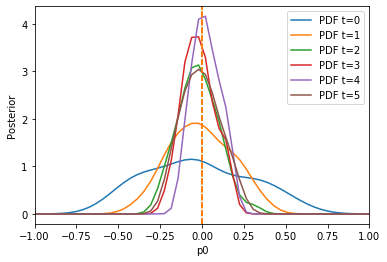

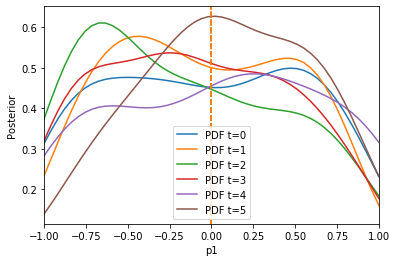

In [4]:
# prior                           
prior = pyabc.Distribution(
    p0=pyabc.RV("uniform", -1, 2),
    p1=pyabc.RV("uniform", -1, 2))

distance = pyabc.AdaptiveAggregatedDistance([distance0, distance1])

abc = pyabc.ABCSMC(model, prior, distance)
db_path = "sqlite:///" + os.path.join(tempfile.gettempdir(), "tmp.db")
abc.new(db_path, observation)
history2 = abc.run(max_nr_populations=6)

plot_history(history2)

The result is much better. We can also only initially calculate weights by setting `adaptive=False`:

INFO:History:Start <ABCSMC(id=17, start_time=2019-10-07 23:08:53.096200, end_time=None)>
INFO:Epsilon:initial epsilon is 0.5645476087317547
INFO:ABC:t:0 eps:0.5645476087317547
INFO:ABC:t:1 eps:0.32402245767741716
INFO:ABC:t:2 eps:0.18008529541539106
INFO:ABC:t:3 eps:0.1065696655673287
INFO:ABC:t:4 eps:0.06230246860624035
INFO:ABC:t:5 eps:0.039531424869316496
INFO:History:Done <ABCSMC(id=17, start_time=2019-10-07 23:08:53.096200, end_time=2019-10-07 23:09:00.445011)>


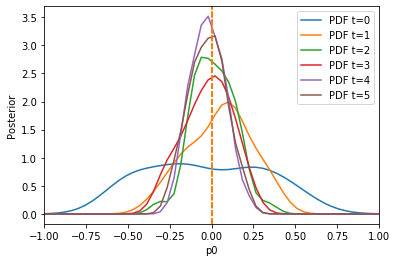

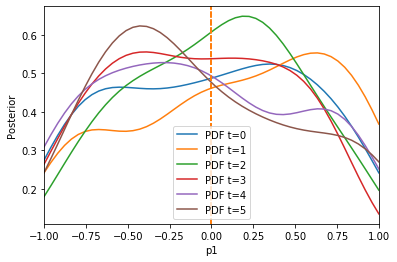

In [5]:
# prior                           
prior = pyabc.Distribution(
    p0=pyabc.RV("uniform", -1, 2),
    p1=pyabc.RV("uniform", -1, 2))

distance = pyabc.AdaptiveAggregatedDistance(
    [distance0, distance1], adaptive=False)

abc = pyabc.ABCSMC(model, prior, distance)
db_path = "sqlite:///" + os.path.join(tempfile.gettempdir(), "tmp.db")
abc.new(db_path, observation)
history3 = abc.run(max_nr_populations=6)

plot_history(history3)

Here, pre-calibration performs comparable to adaptation, because the weights do not change so much over time. Note that one can also specify other scale functions, by passing ``AdaptiveAggregatedDistance(distances, scale_function)``, e.g. ``pyabc.distance.mean[/median/span]``.

The following plots demonstrate that we not only have a much better posterior approximation after the same number of iterations in the second and third run compared to the first, but we achieve that actually with a much lower number of samples.

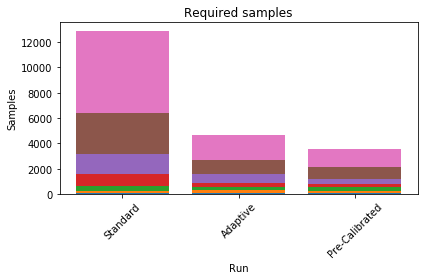

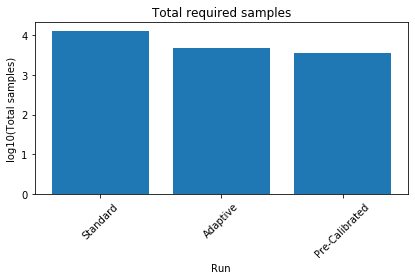

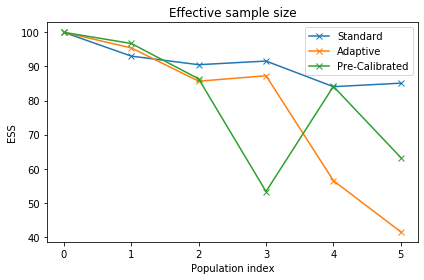

In [6]:
histories = [history1, history2, history3]
labels = ["Standard", "Adaptive", "Pre-Calibrated"]

pyabc.visualization.plot_sample_numbers(histories, labels, rotation=45)
pyabc.visualization.plot_total_sample_numbers(histories, labels, yscale='log10', rotation=45)
pyabc.visualization.plot_effective_sample_sizes(histories, labels)